# Data Loading and Preprocessing

In [1]:
# !pip install seaborn
# !pip install wordcloud
# !pip install scikit-learn

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

## Load Data

In [3]:
data = pd.read_csv('../data/indiana_reports.csv')
data

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,4,"Pulmonary Disease, Chronic Obstructive;Bullous...","Pulmonary Disease, Chronic Obstructive;Bullous...","PA and lateral views of the chest XXXX, XXXX a...",XXXX-year-old XXXX with XXXX.,None available,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,5,Osteophyte/thoracic vertebrae/multiple/small;T...,Osteophyte;Thickening;Lung,Xray Chest PA and Lateral,Chest and nasal congestion.,NaN,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.
...,...,...,...,...,...,...,...,...
3846,3995,Lung/hyperdistention/mild;Diaphragm/bilateral/...,Lung;Diaphragm;Cicatrix;Pulmonary Atelectasis;...,Xray Chest PA and Lateral,"Nausea, vomiting x2 weeks. Dialysis patient.","XXXX, XXXX.",The cardiomediastinal silhouette and pulmonary...,1. Interval resolution of bibasilar airspace d...
3847,3996,Spine/degenerative,Spine,Xray Chest PA and Lateral,NaN,None.,The lungs are clear. Heart size is normal. No ...,Clear lungs. No acute cardiopulmonary abnormal...
3848,3997,Opacity/lung/upper lobe/right/round/small;Gran...,Opacity;Granuloma,PA and lateral views of the chest.,XXXX-year-old male with positive PPD.,None available.,"Heart size within normal limits. Small, nodula...","No acute findings, no evidence for active TB."
3849,3998,normal,normal,"PA and lateral chest XXXX, XXXX XXXX comparis...",tuberculosis positive PPD,NaN,NaN,Heart size is normal and the lungs are clear.


In [4]:
data = data[['findings', 'impression']]

In [5]:
data.head()

,findings,impression
0,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,NaN,"No displaced rib fractures, pneumothorax, or p..."
3,There are diffuse bilateral interstitial and a...,1. Bullous emphysema and interstitial fibrosis...
4,The cardiomediastinal silhouette and pulmonary...,No acute cardiopulmonary abnormality.


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3851 entries, 0 to 3850
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   findings    3337 non-null   object
 1   impression  3820 non-null   object
dtypes: object(2)
memory usage: 60.3+ KB


In [7]:
data.isnull().sum()

findings      514
impression     31
dtype: int64

In [9]:
data = data.dropna()

In [10]:
data.describe()

,findings,impression
count,3331,3331
unique,2547,1346
top,The heart is normal in size. The mediastinum i...,No acute cardiopulmonary abnormality.
freq,51,301


## Preprocess

In [21]:
import re

def preprocess_text(text):

    def lowercase(text):
        return [line.lower() for line in text]

    def decontractions(text):
        contractions = [
            (r"won't", "will not"),
            (r"can\'t", "can not"),
            (r"couldn\'t", "could not"),
            (r"shouldn\'t", "should not"),
            (r"wouldn\'t", "would not"),
            (r"n\'t", " not"),
            (r"\'re", " are"),
            (r"\'s", " is"),
            (r"\'d", " would"),
            (r"\'ll", " will"),
            (r"\'t", " not"),
            (r"\'ve", " have"),
            (r"\'m", " am"),
        ]
        new_text = []
        for phrase in text:
            for old, new in contractions:
                phrase = re.sub(old, new, phrase)
            new_text.append(phrase)
        return new_text

    def rem_punctuations(text):
        punctuations = set('!()-[]{};:\'",<>/?@#$%^&*~')
        return [' '.join(''.join(char for char in line if char not in punctuations).split()) for line in text]

    def rem_numbers(text):
        return [re.sub(r'\d','', re.sub(r'x*','', line)) for line in text]

    def words_filter(text):
        return [' '.join([word for word in line.split() if len(word) > 2 or word in ['no', 'ct']]) for line in text]

    def multiple_fullstops(text):
        return [re.sub(r'\.\.+', '.', line) for line in text]

    def fullstops(text):
        return [re.sub(r'\.', ' .', line) for line in text]

    def multiple_spaces(text):
        return [' '.join(line.split()) for line in text]

    def separating_starting_words(text):
        return [' '.join([word.replace('.', '. ') if word.startswith('.') else word for word in line.split()]) for line in text]

    def rem_apostrophes(text):
        return [line.replace("'", '') for line in text]

    text = lowercase(text)
    text = decontractions(text)
    text = rem_punctuations(text)
    text = rem_numbers(text)
    text = words_filter(text)
    text = multiple_fullstops(text)
    text = fullstops(text)
    text = multiple_spaces(text)
    text = separating_starting_words(text)
    text = rem_apostrophes(text)

    return text

In [24]:
data['findings'] = preprocess_text(data['findings'])
data['impression'] = preprocess_text(data['impression'])

In [25]:
data.head()

,findings,impression
0,the cardiac silhouette and mediastinum size ar...,normal chest
1,borderline cardiomegaly midline sternotomy enl...,no acute pulmonary findings .
3,there are diffuse bilateral interstitial and a...,bullous emphysema and interstitial fibrosis . ...
4,the cardiomediastinal silhouette and pulmonary...,no acute cardiopulmonary abnormality .
5,heart size and mediastinal contour are within ...,no acute cardiopulmonary findings .


## EDA

### Character counts

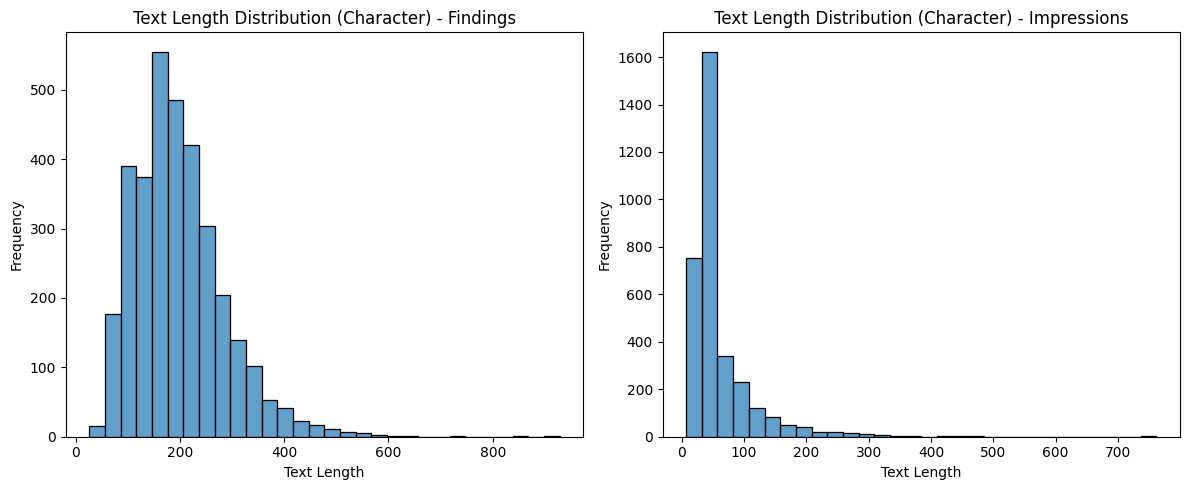

In [37]:
# histogram of text length (characters)
plt.figure(figsize=(12, 5))

# findings
plt.subplot(1, 2, 1)
sns.histplot(data['findings'].astype(str).apply(len), bins=30, alpha=0.7)
plt.title('Text Length Distribution (Character) - Findings')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# impression
plt.subplot(1, 2, 2)
sns.histplot(data['impression'].astype(str).apply(len), bins=30, alpha=0.7)
plt.title('Text Length Distribution (Character) - Impressions')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Word counts

In [38]:
data['findings'].apply(lambda x: len(x.split()))

0       27
1       10
3       56
4       38
5       28
        ..
3844    16
3845    17
3846    62
3847    15
3848    26
Name: findings, Length: 3331, dtype: int64

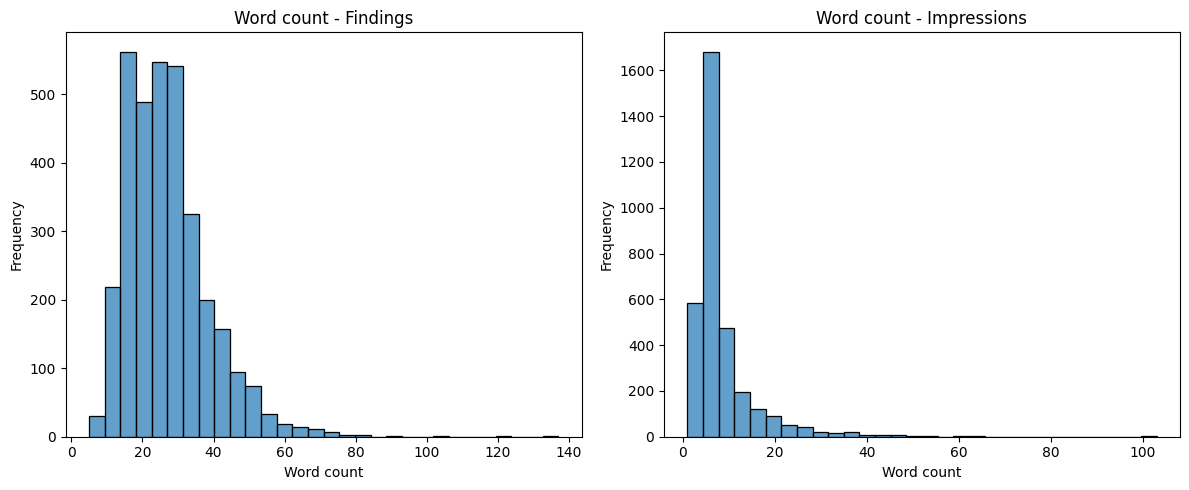

In [40]:
# histogram of word counts
plt.figure(figsize=(12, 5))

# findings
plt.subplot(1, 2, 1)
sns.histplot(data['findings'].apply(lambda x: len(x.split())), bins=30, alpha=0.7)
plt.title('Word count - Findings')
plt.xlabel('Word count')
plt.ylabel('Frequency')

# impression
plt.subplot(1, 2, 2)
sns.histplot(data['impression'].apply(lambda x: len(x.split())), bins=30, alpha=0.7)
plt.title('Word count - Impressions')
plt.xlabel('Word count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [41]:
# wordcloud

def plot_wordcloud(df, column_name, title='Word Cloud'):
    """
    plot a word cloud from a specified column of a df.
    """
    text = ' '.join(df[column_name].astype(str))

    wordcloud = WordCloud(width=800, height=400, collocations=False,
                          max_font_size=180, background_color='white').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

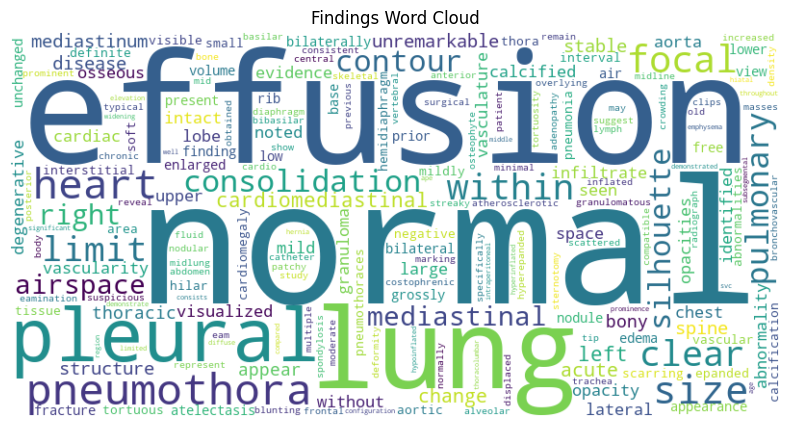

In [42]:
# findings
plot_wordcloud(data, 'findings', title='Findings Word Cloud')

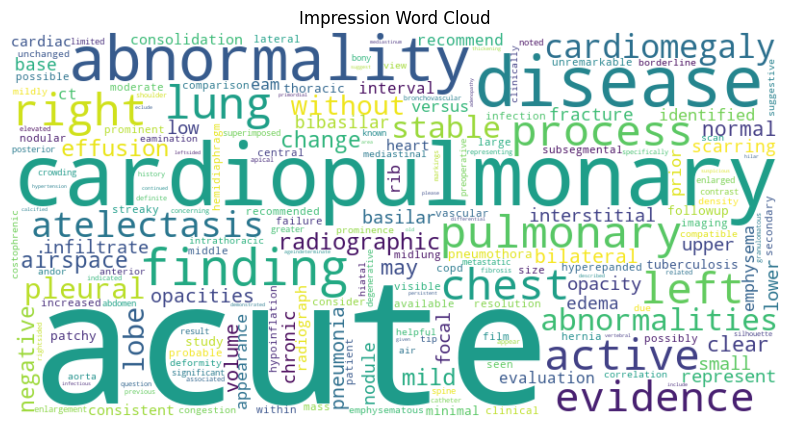

In [46]:
# impression
plot_wordcloud(data, 'impression', title='Impression Word Cloud')

## Train Test Split

In [49]:
from sklearn.model_selection import train_test_split


train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
test_data, val_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f'Train set size: {train_data.shape[0]}')
print(f'Test set size: {test_data.shape[0]}')
print(f'Validation set size: {val_data.shape[0]}')

Train set size: 2331
Test set size: 500
Validation set size: 500


In [50]:
os.makedirs('../data/preprocessed', exist_ok=True)

train_data.to_csv('../data/preprocessed/train.csv', index=False)
test_data.to_csv('../data/preprocessed/test.csv', index=False)
val_data.to_csv('../data/preprocessed/val.csv', index=False)

print("Saved preprocessed datasets.")

Saved preprocessed datasets.
